# Zinser data (regridded)

In [1]:
import netCDF4 as nc4
import numpy as np

# load data
datafile = 'data/Zinser_SizeDist_regrid-20-7.nc'

data_gridded = {}
with nc4.Dataset(datafile) as nc:
    for var in nc.variables:
        data_gridded[var] = nc.variables[var][:]

In [2]:
v_min = data_gridded['v_min']
delta_v = 1.0/data_gridded['delta_v_inv']
v = v_min * 2**(np.arange(data_gridded['m'])*delta_v) 

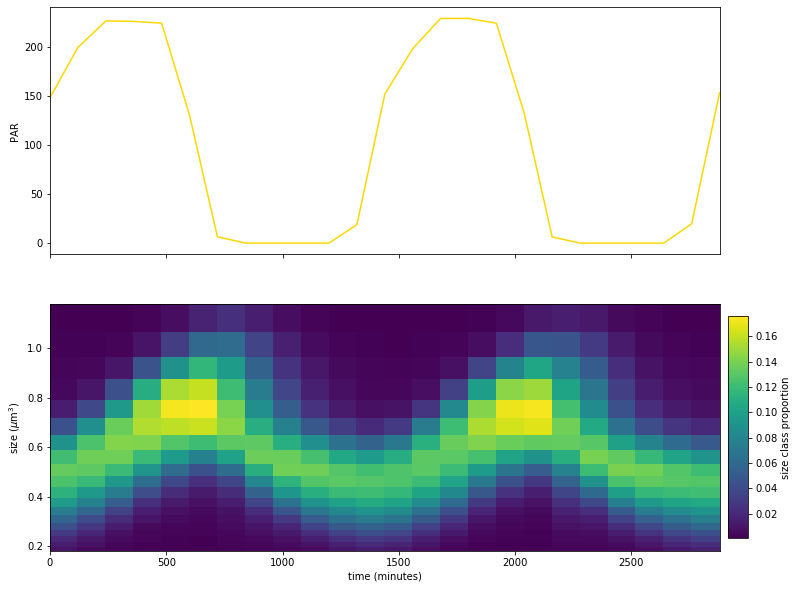

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

fig,axs = plt.subplots(nrows=2, sharex=True, figsize=(12,10))

ax = axs[0]
ax.plot(data_gridded['time'], data_gridded['PAR'], color='gold')
ax.set(ylabel='PAR')

ax = axs[1]
pc = ax.pcolormesh(data_gridded['time'],v,data_gridded['w_obs'])
ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [4]:
stan_code = '''data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    matrix[m, nt_obs] obs; //observations
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0, upper=1.0/dt_days> delta_max[m-j+1]; 
    real<lower=0> gamma_mu; 
    real<lower=0> gamma_sigma; 
    real<lower=0, upper=1.0/dt_days> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma;
    real<lower=0> rho_mu;
    real<lower=0> rho_sigma;
    real<lower=0, upper=0.3*gamma_max> rho;
}
transformed parameters {
    real divrate;
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr;
        vector[m] w_next;
        vector[m] u_curr;
        vector[m] u_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        //vector[m] tmp;
        int ito = 1;
        int resp;
        
        w_curr = w_ini;
        u_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            
            /*tmp = obs[,ito];
            w_curr = tmp ./ sum(tmp);*/
            w_next = rep_vector(0.0, m);
            u_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute gamma
                if (i == 1){
                //if (i < m){
                    gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star));
                } else if (i < m){
                    gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star)) - rho * dt_days;
                    if (gamma < 0){
                        resp = 1;
                        gamma = -gamma;
                    } else{
                        resp = 0;
                    }
                } else if (i == m){
                    gamma = rho * dt_days;
                    resp = 1;
                }
                
                // compute delta_i
                if (i >= j){
                    delta_i = delta_max[i-j+1] * dt_days;
                }
                
                // fill subdiagonal (growth)
                if (i < j && resp == 0){
                //if(i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                    u_next[i+1] += a * u_curr[i];
                } else if (i < m && resp == 0){
                //} else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                    u_next[i+1] += a * u_curr[i];
                }
                
                // fill the 1st superdiagonal (respiration)
                if (i < j && i > 1 && resp == 1){
                    a = gamma;
                    w_next[i-1] += a*w_curr[i];
                    u_next[i-1] += a*u_curr[i];
                } else if (i >= j && resp == 1){
                    a = gamma * (1.0 - delta_i);
                    w_next[i-1] += a*w_curr[i];
                    u_next[i-1] += a*u_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                    u_next[i+1-j] += a * u_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                    u_next[i] += a * u_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                    u_next[i] += a * u_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                    u_next[i] += a * u_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
            u_curr = u_next;
        }
        divrate = log(sum(u_curr))*60*24/(nt*dt); // daily division rate
    }
}
model {
    real diff;
    
    // priors
    /*delta_mu ~ normal(66.0, 5.0);
    delta_sigma ~ exponential(1.0);
    delta_max ~ normal(delta_mu, delta_sigma);
    gamma_mu ~ normal(55.0, 5.0);
    gamma_sigma ~ exponential(1.0);
    gamma_max ~ normal(gamma_mu, gamma_sigma);
    E_star ~ normal(300.0,100.0);
    rho_mu ~ normal(16.5, 5.0);
    rho_sigma ~ exponential(1.0);
    rho ~ normal(rho_mu, rho_sigma);
    
    sigma ~ exponential(1000.0);*/
    
    delta_mu ~ lognormal(log(66.0), 5.0);
    delta_sigma ~ exponential(0.1);
    delta_max ~ lognormal(delta_mu, delta_sigma);
    gamma_mu ~ lognormal(log(55.0), 5.0);
    gamma_sigma ~ exponential(0.1);
    gamma_max ~ lognormal(gamma_mu, gamma_sigma);
    E_star ~ lognormal(log(300.0), 10.0);
    rho_mu ~ lognormal(log(16.5), 5.0);
    rho_sigma ~ exponential(0.1);
    rho ~ lognormal(rho_mu, rho_sigma);
    
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
'''

In [5]:
# prepare data for Stan model

dt = 20 # in units of minutes

data = {'dt':dt}
for k in ('m','v_min','delta_v_inv'):
    data[k] = data_gridded[k]

data['obs'] = data_gridded['w_obs']
data['t_obs'] = data_gridded['time']
data['E'] = data_gridded['PAR']
# use first measurements as initial conditions
data['w_ini'] = data_gridded['w_obs'][:,0]

# limit the data

limit_days = 1
stride_t_obs = 1 # keep everything

if limit_days > 0:
    limit_minutes = limit_days*1440 # The plus 500 term is for the Zinser data
    
    ind_obs = data['t_obs'] < limit_minutes
    data['t_obs'] = data['t_obs'][ind_obs]
    data['obs'] = data['obs'][:,ind_obs]

    data['nt'] = int(limit_minutes//data['dt'])
    
if stride_t_obs > 0:
    data['t_obs'] = data['t_obs'][::stride_t_obs]
    data['obs'] = data['obs'][:,::stride_t_obs]

data['nt_obs'] = data['obs'].shape[1]

# finally, add light data
t = np.arange(data['nt'])*data['dt']
data['E'] = np.interp(t, xp=data_gridded['time'], fp=data_gridded['PAR'])

In [6]:
import pystan

model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e62b3b227a99b8e13319d32f8c4a5d4 NOW.


In [7]:
mcmc = model.sampling(data=data, iter=2000)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'mod_obspos' not in x))

Inference for Stan model: anon_model_4e62b3b227a99b8e13319d32f8c4a5d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu            0.25  8.6e-3   0.49 1.3e-4   0.01   0.07   0.27   1.62   3232    1.0
delta_sigma         8.92    0.22   3.97   3.38   5.92   8.26  11.11  18.87    330   1.01
delta_max[1]        0.06  2.4e-3   0.154.5e-11 4.3e-5 3.7e-3   0.05   0.51   3703    1.0
delta_max[2]        0.03  1.2e-3   0.067.5e-11 2.3e-5 1.9e-3   0.03   0.22   2565    1.0
delta_max[3]        0.02  9.4e-4   0.055.7e-11 2.3e-5 1.1e-3   0.02   0.17   2526    1.0
delta_max[4]        0.02  7.6e-4   0.047.2e-11 2.0e-5 1.1e-3   0.01   0.13   2362    1.0
delta_max[5]        0.02  8.6e-4   0.044.1e-11 1.7e-5 9.9e-4   0.01   0.15   2309    1.0
delta_max[6]        0.02  9.8e-4   0.053.9e-11 1.4e-5 1.1e-3   0.02   0.17   2668    1.0
delta_max[

## Plot the results

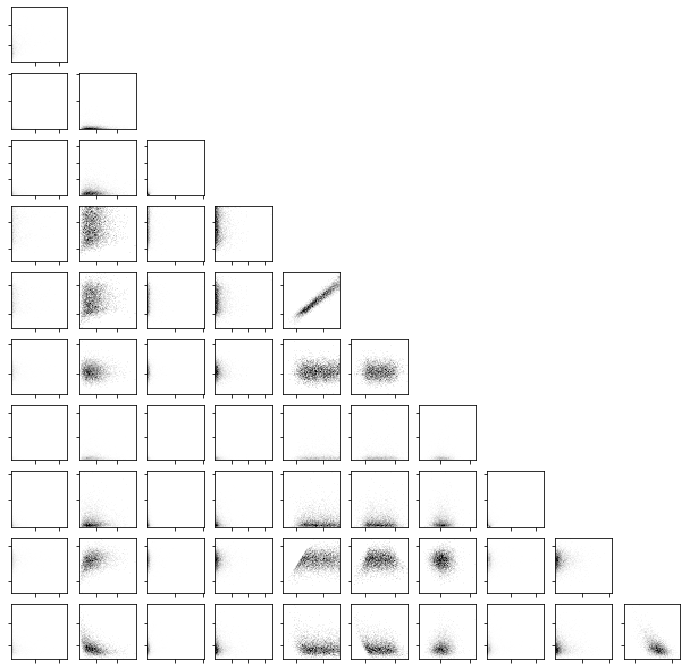

In [8]:
paramnames = [v for v in mcmc.flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max') and not '[' in v]
num_params = len(paramnames)

fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
for ax in axs.flat:
    ax.set_visible(False)
for irow in range(1,num_params):
    for icol in range(irow):
        ax = axs[irow-1,icol]
        ax.set_visible(True)
        xname = paramnames[icol]
        yname = paramnames[irow]
        ax.hist2d(mcmc[xname],mcmc[yname],bins=50,cmap=mpl.cm.gray_r)
        if icol == 0:
            ax.set_ylabel(yname)
        if irow == num_params-1:
            ax.set_xlabel(xname)
None

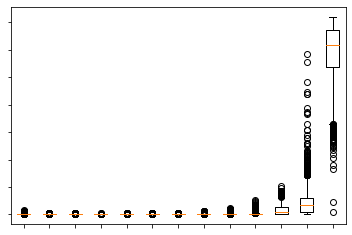

In [9]:
j = data_gridded['delta_v_inv'] + 1
m = data_gridded['m']
fig, ax = plt.subplots()
ax.boxplot(mcmc['delta_max'])
xlabels = [str(x) for x in range(j,m+1)]
xlabels[0] = 'j='+xlabels[0]
xlabels[-1] = 'm='+xlabels[-1]
ax.set_xticklabels(xlabels)
None

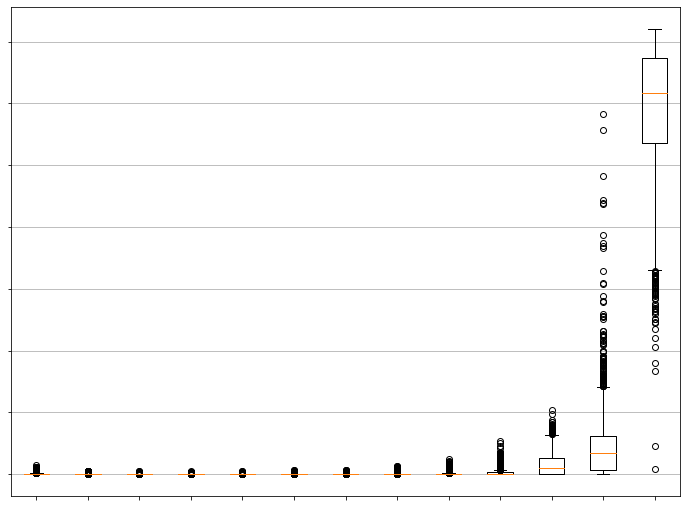

In [10]:
j = data_gridded['delta_v_inv'] + 1
m = data_gridded['m']

fig, axs = plt.subplots(nrows=1, sharex=True, figsize=(12,9))
ax = axs
ax.boxplot(mcmc['delta_max'], positions=range(j,m+1))
ax.set(ylabel='delta_i')
ax.yaxis.grid(True)
ax.title.set_text('Division Proportion vs. Size Class')

# ax = axs[1]
# ax.boxplot(mcmc['gamma_max'], positions=range(1,m))
# ax.set(ylabel='gamma_max')
# ax.yaxis.grid(True)

# ax = axs[2]
# ax.boxplot(mcmc['rho'], positions=range(1,m))
# ax.set(ylabel='rho')
# ax.yaxis.grid(True)

xlabels = [str(x) for x in range(1,m+1)]
None

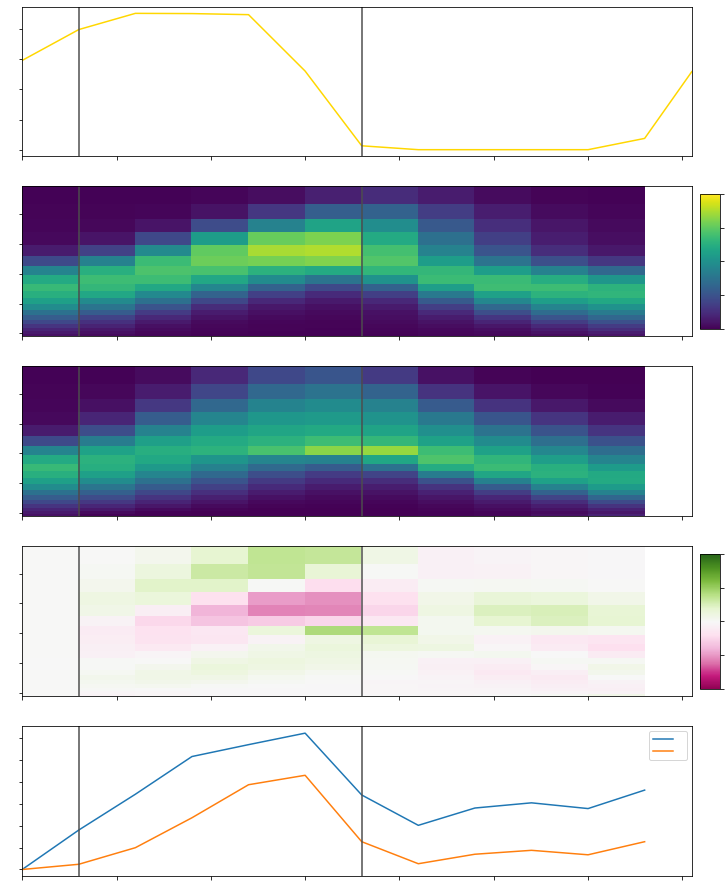

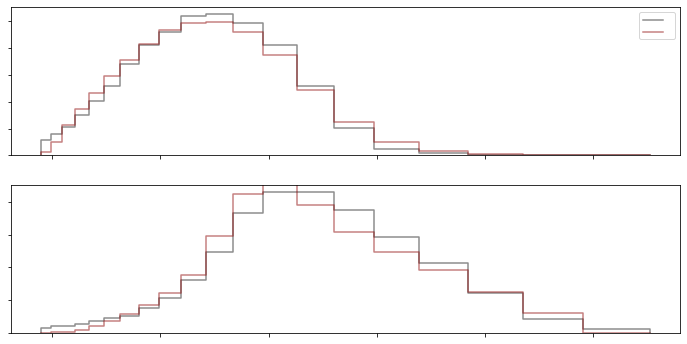

In [11]:
res = {'model':np.mean(mcmc['mod_obspos'], axis=0), 'obs':data['obs']}
colors = {'model':'darkred', 'obs':'0.1'}

diff = res['model']-res['obs']

t = data['dt']*np.arange(data['nt'])
slice_indices = [1,6]
v_ext = data['v_min'] * 2**(np.arange(data['m']+1)*delta_v) 
v_width = v_ext[1:] - v_ext[:-1]

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

fig,axs = plt.subplots(5,1,sharex=True,figsize=(12,16))

ax = axs[0]
ax.plot(t, data['E'], color='gold')
ax.set(xlim=(data['t_obs'][0],t[-1]), ylabel='E ($\mu$mol photons/m$^{2}$/s)')

ax = axs[1]
pc = ax.pcolormesh(data['t_obs'],v,res['obs'],norm=norm)
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

ax = axs[2]
ax.set(ylabel='size ($\mu$m$^3$)')
pc = ax.pcolormesh(data['t_obs'],v,res['model'],norm=norm)

ax = axs[3]
pc = ax.pcolormesh(data['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
ax.set(ylabel='size ($\mu$m$^3$)')
add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

ax = axs[4]
prop = np.mean(np.abs(diff),axis=0)
ax.plot(data['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
prop = np.sum(diff**2,axis=0)
ax.plot(data['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
ax.set(xlabel='time (days)', ylabel='model-observation misfit')
ax.legend()

for ax in axs.flat:
    for i in slice_indices:
        ax.axvline(data['t_obs'][i], color='.3')

# plot slices

plotdata_y = np.zeros(2*(data['m']+1))

fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
for i,ax in zip(slice_indices,axs.flat):
    for name in ('obs','model'):
        color = colors[name]
        cdata = res[name][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
        ax.text(0.01, 0.95, 'minute {}'.format(data['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
        ax.set_ylabel('density')
        ax.set_ylim(bottom=0.0)
axs[0].legend()
None